In [9]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax

# Lets make a little toy model

In [10]:
# Lets read in only the most massive halo
data = np.load('Data/first_1_SB28.npz')
usable_data = np.nonzero(data['Y'])[0]
Y_mean = np.log10(data['Y'][usable_data, 0])
Mass = np.log10(data['M'][usable_data, 0]*1e10)

params = np.load('Data/SB28_params.npy')[usable_data, :]
params_ =pd.read_csv('Data/SB28_param_minmax.csv')

X = np.vstack((params.T, Mass.T)).T
for i, Xi in enumerate(X.T[:-1]):
    if params_['LogFlag'][i] == 1:
        X[:, i] = 10**X[:, i]
X = (X - X.min(axis = 0)) / X.max(axis = 0)

In [11]:
import jaxopt
from tinygp import GaussianProcess, kernels, transforms


def train_gp(nparams, build_gp_func, X, y):
    @jax.jit
    def loss(params):
        return -build_gp_func(params, X).log_probability(y)

    params = {
        "log_amp": 0.0,
        "log_scale" : -2*np.ones(29),
        "log_jitter": -1.0,
    }
    solver = jaxopt.ScipyMinimize(fun=loss)
    soln = solver.run(params)
    return build_gp_func(soln.params, X)


def build_gp_uncorr(params, X):
    kernel = jnp.exp(params["log_amp"])* transforms.Linear(jnp.exp(params["log_scale"]), kernels.ExpSquared())
    return GaussianProcess(kernel, X, diag=jnp.exp(params["log_jitter"]))

In [12]:
uncorr_gp = train_gp(29, build_gp_uncorr, X, Y_mean)

In [13]:
sigma = np.sqrt(uncorr_gp.noise.diag[0])

In [14]:
data = np.load('Data/first_1_1P.npz')
T = np.log10(data['Y'])
M = np.log10(data['M'].flatten()*1e10)
data = np.load('Data/first_1_1P_extended.npz')
T_extended = np.log10(data['Y'])[:, :, 0]
M_extended = np.log10(data['M'][:, :, 0]*1e10).flatten()
T_extended[:, 2] = T_extended[0, 2]
M = np.concatenate((M, M_extended))
params =pd.read_csv('Data/SB28_param_minmax.csv')
param_vals = np.zeros((176, 28))
for i in range(28):
    param_vals[:, i] = params.loc[i, 'FiducialVal']
start = 0
for i in range(28):
    if i<6:
        nsims = 11
    else:
        nsims = 5
    if bool(params.loc[i, 'LogFlag']):
        ps = np.logspace(np.log10(params.loc[:, 'MinVal'][i]), np.log10(params.loc[:, 'MaxVal'][i]), nsims, endpoint=True)
    else:
        ps = np.linspace(params.loc[:, 'MinVal'][i], params.loc[:, 'MaxVal'][i], nsims, endpoint=True)
    stop = start +nsims
    param_vals[start:stop, i] = ps
    start = stop    
param_df = pd.DataFrame(param_vals, columns=np.array(params.loc[:, 'ParamName']))
param_df['M'] = M
param_df = (param_df - param_df.min(axis=0))/param_df.max(axis=0)

model = uncorr_gp.predict(Y_mean, np.array(param_df))

test_theta=np.array(param_df)

In [16]:
def generate_theta(param_df,N, seed, d=7):
    from scipy.stats import qmc
    lbs = list(param_df.min())
    ubs = list(param_df.max())
    sampler = qmc.Sobol(d=d, scramble=True, seed=seed)
    sample = sampler.random_base2(m=N)
    theta = qmc.scale(sample, lbs, ubs).T
    return theta
def generate_model(theta, uncorr_gp, Y_mean, seed=1992, sigma=0.5):
    T = uncorr_gp.predict(Y_mean, theta.T)
    np.random.seed(seed)
    data = np.random.normal(T, sigma, theta.shape[1])
    intrinsic_noise = T - data
    return data, intrinsic_noise
def generate_surrogates(theta, intrinsic_noise,uncorr_gp, Y_mean, Groups=2**4):
    ## Different split approach
    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(int(Groups)).fit(theta.T)
    labels = clustering.labels_
    unique_ls, counts = np.unique(labels, return_counts=True)
    theta_R = np.vstack([[np.mean(theta[:, labels==i], axis=1)]*c for i, c in zip(unique_ls, counts)])
    noises = np.concatenate([intrinsic_noise[labels==i] for i, c in zip(unique_ls, counts)])
    surrogate_raw = uncorr_gp.predict(Y_mean, theta_R)
    surrogate_data = surrogate_raw + noises 
    return theta_R, surrogate_data, surrogate_raw

In [17]:
theta = generate_theta(param_df, N=7, seed=1994, d=29)
    
data, intrinsic_noise = generate_model(theta, 
                                       uncorr_gp, 
                                       Y_mean, 
                                       seed=1992, sigma=sigma)

theta_R, surrogate_data, surrogate_raw = generate_surrogates(
                                                theta, 
                                                intrinsic_noise, 
                                                uncorr_gp,
                                                Y_mean, 
                                                Groups=50)

Now we have the starting points, data, and surrogates/surrogate data. We can get a crack on then! 

# Now we can use CARPoolGP

In [18]:
from src import CARPoolSimulations

# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters = theta; sims.quantities=data
surrs.parameters = theta_R; surrs.quantities=surrogate_data

In [19]:
from src import CARPoolEmulator

#Build an emulator 
emu = CARPoolEmulator.Emulator(sims, surrs)

#Initialize some set of parameters (or default)
params = {"log_scaleV":0.1,
          "log_ampV":1.0,
          "log_scaleW":1.0,
          "log_ampW":1.0,
          "log_scaleX":0.0,
          "log_ampX":0.0,                
          "log_scaleM":0.0,
          "log_ampM":0.0,
          "log_deltaP":0.0,
          "log_jitterV":1.0,
          "log_jitterW":1.0,
          "log_mean":0.0}

# Train the emulator
emu.train(learning_rate=1e-3, max_iterations=1000)

# now emulate! 
pred_mean, pred_var = emu.predict(theta)

ValueError: cannot reshape array of size 1450 into shape (128)

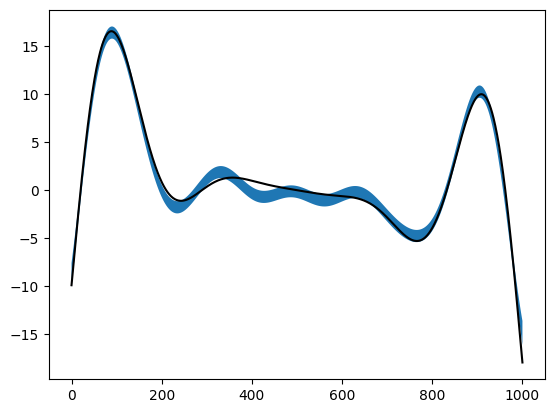

In [6]:

std = np.sqrt(np.diag(pred_var))
plt.fill_between(np.arange(1001), pred_mean - std, pred_mean+std)
plt.plot(Y, 'k')


# Active learning approach

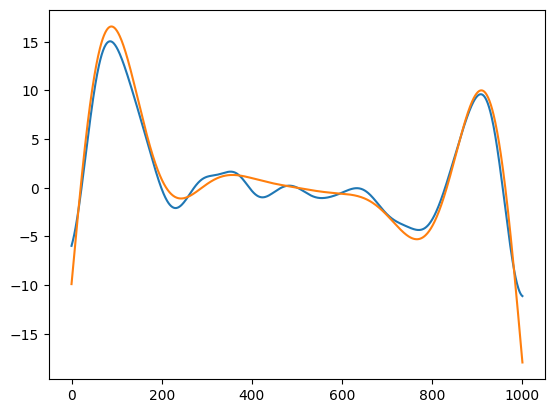

In [21]:
from src import CARPoolEmulator

# Generate an active learning model
model = CARPoolEmulator.ActiveLearning(sims, surrs, theta, Domain[0], Domain[1])

# Initialize the training
best_params = model.train(learning_rate=1e-3, max_iterations=100)
pred_test, pred_var = model.predict(theta)
plt.plot(pred_test)
plt.plot(Y)

In [22]:
# Run an active learning step to find the next state (Ngrid is for 2**N)
next_thetas, next_surrogates = model.active_learning_step(num_new=6, Ngrid=5)

In practice we would now run simulations at these new points, but lets say we have a model that is the simulation. then we can update the simulations and re train

In [23]:
next_data, next_noise = model_data(next_thetas)
next_surrogate_data = model_data(next_surrogates, next_noise)
model.Simulations.update(next_thetas, next_data)
model.Surrogates.update(next_surrogates, next_surrogate_data)
best_params = model.train(learning_rate=1e-3, max_iterations=100)
pred_test, pred_var = model.predict(theta)
plt.plot(pred_test)
plt.plot(Y)

In [26]:
# Now we can iteratively do this:
pred_tests = []
pred_vars = []

# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters = theta_Q; sims.quantities=Q
surrs.parameters = theta_R; surrs.quantities=R

# Generate an active learning model
model = CARPoolEmulator.ActiveLearning(sims, surrs, theta, Domain[0], Domain[1])

# Initialize the training
best_params = model.train(learning_rate=1e-3, max_iterations=1000)
pred_test, pred_var = model.predict(theta)
pred_tests.append(pred_test)
pred_vars.append(pred_var)

for i in range(4):
    # Run an active learning step to find the next state (Ngrid is for 2**N)
    next_thetas, next_surrogates = model.active_learning_step(num_new=20, Ngrid=7)   

    next_data, next_noise = model_data(next_thetas)
    next_surrogate_data   = model_data(next_surrogates, next_noise)

    model.Simulations.update(next_thetas, next_data)
    model.Surrogates.update(next_surrogates, next_surrogate_data)

    best_params = model.train(best_params, learning_rate=1e-3, max_iterations=1000)
    
    pred_test, pred_var = model.predict(theta)
    pred_tests.append(pred_test)
    pred_vars.append(pred_var)